In [1]:
import numpy as np
from tqdm import tqdm
from astropy.io import fits
from astropy.wcs import WCS
import jax.numpy as jnp
import os
from perch.perch_ph import PH
from perch.perch_structures import Structures
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
#from persim import PersImage
from persim import PersistenceImager
from PIL import Image
from skimage import color
from skimage import io
import matplotlib.image as mpimg
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

# Load data

(array([ 7977.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10899.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

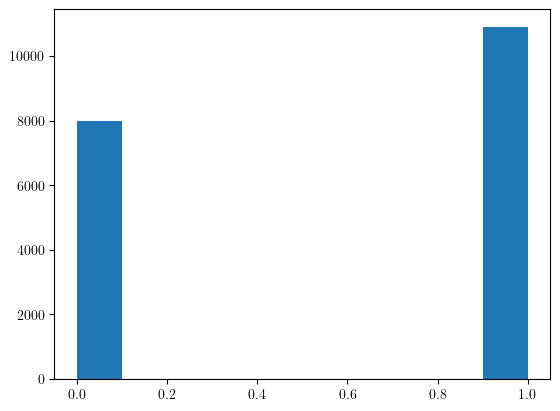

In [2]:
gz_img_ids = pd.read_csv('/Users/toneill/Downloads/gz2_filename_mapping.csv')
gz_img_ids.columns = ['dr7objid', 'sample', 'asset_id']

gz_tab = Table.read('/Users/toneill/Downloads/gz2_hart16.fits').to_pandas()
gz_df = pd.merge(gz_img_ids,gz_tab,on='dr7objid')
gz_df.columns = np.where(gz_df.columns=='gz2_class' , 'gz2class',gz_df.columns)
gz_df['gz2class'] = [i.decode() for i in gz_df['gz2class'].values]

has_arms = (gz_df['gz2class'].str.contains('1') +\
            gz_df['gz2class'].str.contains('2') +\
            gz_df['gz2class'].str.contains('3') +\
           gz_df['gz2class'].str.contains('4') + \
            (gz_df['gz2class'].str.find('+') > 0)#+ \
            #(gz_df['gz2class'].str.find('?') > 0)
            )
gz_df['spiral'] =gz_df['gz2class'].str.startswith('S') & has_arms
gz_df['ell'] =gz_df['gz2class'].str.startswith('Er')
sell_df = gz_df[gz_df['spiral'] + gz_df['ell']].reset_index()

ddir = '/Users/toneill/Downloads/galaxy_zoo_images/'
file_exists = [os.path.isfile(f"{ddir}{sell_df['asset_id'].values[i]}.jpg") for i in range(len(sell_df))]
sell_df = sell_df[file_exists].reset_index(drop=True)

train_df =sell_df.sample(int(len(sell_df)/5))
#train_df = sell_df
train_df['class'] = np.where(train_df['spiral'],1,0)

plt.figure()
plt.hist(train_df['class'])

# Perch Calculation for each galaxy

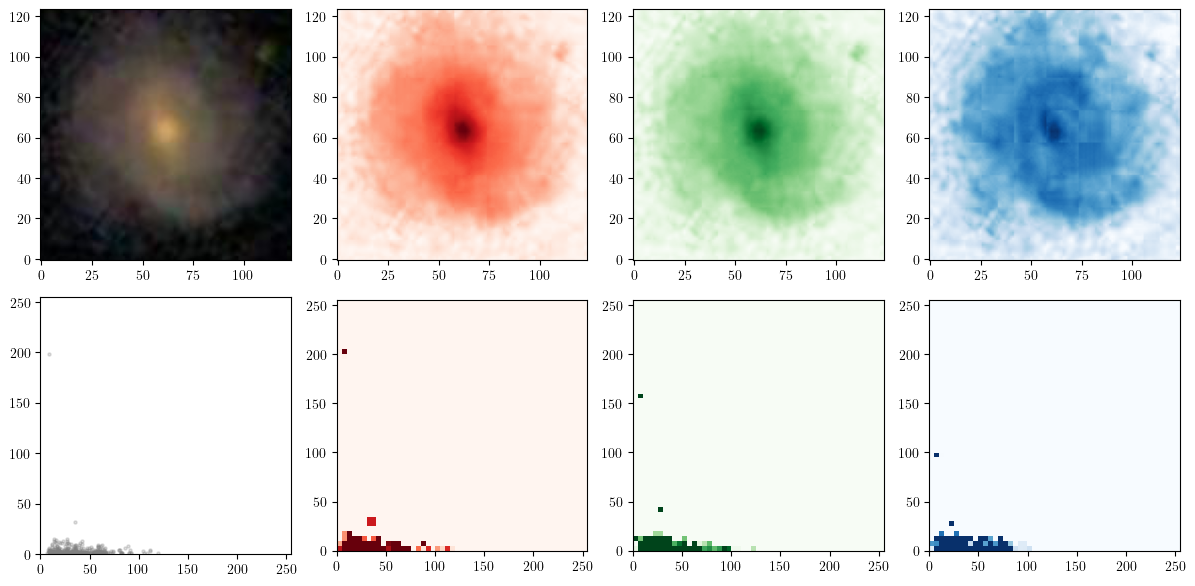

In [9]:
### plot example galaxy

show_plot = True
df_use = train_df

trim_bord = 150

gal_id = df_use['asset_id'].values[np.random.randint(0,len(df_use),1)][0]
#img_use = np.array(Image.open(f'{ddir}{gal_id}.jpg').convert('L'),dtype='float32')[trim_bord:-trim_bord,trim_bord:-trim_bord]
img = mpimg.imread(f'{ddir}{gal_id}.jpg')
img_use = np.array(img[trim_bord:-trim_bord,trim_bord:-trim_bord,:],dtype='float32')

#hom = PH.compute_hom(img_use,verbose=False,engine='C',flip_data=True,max_Hi=0)
pimgr = PersistenceImager(pixel_size=5,birth_range=(0,255),pers_range=(0,255))
pimgr.kernel_params = {'sigma': .1}
#per_img0 = pimgr.transform(hom.generators[:,[2,1]][hom.generators[:,0]==0])

hom = PH.compute_hom(img_use[:,:,0],verbose=False,engine='C',flip_data=True,max_Hi=0)
per_img_r = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==0)])# & (hom.generators[:,5]==0)])
hom = PH.compute_hom(img_use[:,:,1],verbose=False,engine='C',flip_data=True,max_Hi=0)
per_img_g = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==0)])# & (hom.generators[:,5]==1)])
hom = PH.compute_hom(img_use[:,:,2],verbose=False,engine='C',flip_data=True,max_Hi=0)
per_img_b = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==0)])# & (hom.generators[:,5]==2)])

if show_plot:
        img = mpimg.imread(f'{ddir}{gal_id}.jpg')
        img_crop = img[trim_bord:-trim_bord,trim_bord:-trim_bord,:]

        fig, axs  = plt.subplots(2,4,figsize=(12,6))
        axs = axs.ravel()
        ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = axs
        ax1.imshow(img_crop,origin='lower')
        ax2.imshow(img_crop[:,:,0],origin='lower',cmap='Reds')
        ax3.imshow(img_crop[:,:,1],origin='lower',cmap='Greens')
        ax4.imshow(img_crop[:,:,2],origin='lower',cmap='Blues')
        #ax1.set_title(f"class={df_use['gz2class'].values[i]}")

        hom_all = PH.compute_hom(img_use,verbose=False,engine='C',flip_data=True,max_Hi=0)
        ax5.scatter(hom_all.generators[:,2],hom_all.generators[:,1]-hom_all.generators[:,2],#s=1,
                   s=5,alpha=0.25,c='grey')
        ax5.set_xlim(0,255)
        ax5.set_ylim(0,255)
        #ax5.set_xlabel('death')
        #ax5.set_ylabel('lifetime')

        ax6.imshow((per_img_r).T,origin='lower',extent=[0,255,0,255],vmax=10,cmap='Reds')
        ax7.imshow((per_img_g).T,origin='lower',extent=[0,255,0,255],vmax=10,cmap='Greens')
        ax8.imshow((per_img_b).T,origin='lower',extent=[0,255,0,255],vmax=10,cmap='Blues')
        
        fig.tight_layout()


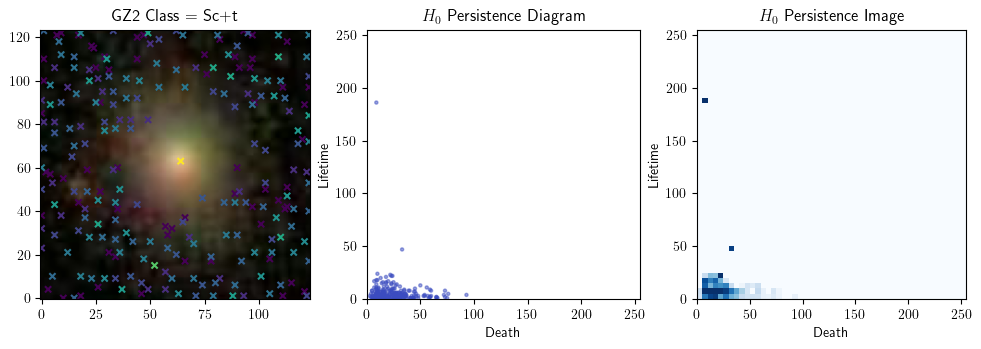

In [256]:
### plot example galaxy

show_plot = True
df_use = train_df

trim_bord = 150

gal_id = df_use['asset_id'].values[np.random.randint(0,len(df_use),1)][0]
#img_use = np.array(Image.open(f'{ddir}{gal_id}.jpg').convert('L'),dtype='float32')[trim_bord:-trim_bord,trim_bord:-trim_bord]

if show_plot:

    img_use = np.array(Image.open(f'{ddir}{gal_id}.jpg').convert('L'),dtype='float32')[trim_bord:-trim_bord,trim_bord:-trim_bord]
    i = np.where(df_use['asset_id']==gal_id)[0]

    hom = PH.compute_hom(img_use,verbose=False,engine='C',flip_data=True,max_Hi=0)
    
    pimgr = PersistenceImager(pixel_size=5,birth_range=(0,255),pers_range=(0,255))
    pimgr.kernel_params = {'sigma': .1}
    #per_img = pimgr.transform(hom.generators[:,[2,1]])
    per_img0 = pimgr.transform(hom.generators[:,[2,1]][hom.generators[:,0]==0])
    #per_img1 = pimgr.transform(hom.generators[:,[2,1]][hom.generators[:,0]==1])
    
    img = mpimg.imread(f'{ddir}{gal_id}.jpg')
    img_crop = img[trim_bord:-trim_bord,trim_bord:-trim_bord,:]

    fig, [ax1,ax2,ax3]  = plt.subplots(1,3,figsize=(12,3.5))
    ax1.imshow(img_crop,origin='lower')
    ax1.scatter(hom.generators[:,3],hom.generators[:,4],c=np.log10(hom.generators[:,1]-hom.generators[:,2]),cmap='viridis',s=20,marker='x')
    ax1.set_title(f"GZ2 Class = {df_use['gz2class'].values[i][0]}")
    #ax1.axis('off')

    ax2.scatter(hom.generators[:,2],hom.generators[:,1]-hom.generators[:,2],#s=1,
                    c=hom.generators[:,0],s=5,alpha=0.5,cmap='coolwarm')
    ax2.set_xlim(0,255)
    ax2.set_ylim(0,255)
    ax2.set_xlabel('Death')
    ax2.set_ylabel('Lifetime')
    ax2.set_title('$H_0$ Persistence Diagram')

    ax3.imshow((per_img0).T,origin='lower',extent=[0,255,0,255],vmax=50,cmap='Blues')#,origin='lower')#,vmax=1)#,origin='lower')#,vmax=1)#,vmin=-3)
    ax3.set_xlabel('Death')
    ax3.set_ylabel('Lifetime')
    ax3.set_title('$H_0$ Persistence Image')


In [242]:
np.shape(img_use)

(124, 124)

In [229]:
### run on all galaxies
save_per_imgs = []
flat_imgs = []
df_use = train_df
trim_bord = 100

i = 0
show_plot = False

t1 = time.time()
pbar = tqdm(total=len(df_use), unit='galaxies')
for gal_id in df_use['asset_id']:#

    img_use = np.array(Image.open(f'{ddir}{gal_id}.jpg').convert('L'),dtype='float32')[trim_bord:-trim_bord,trim_bord:-trim_bord]

    hom = PH.compute_hom(img_use,verbose=False,engine='C',flip_data=True,max_Hi=1)
    
    pimgr = PersistenceImager(pixel_size=5,birth_range=(0,255),pers_range=(0,255))#17
    pimgr.kernel_params = {'sigma': .1}
    #per_img = pimgr.transform(hom.generators[:,[2,1]])
    per_img0 = pimgr.transform(hom.generators[:,[2,1]][hom.generators[:,0]==0])
    per_img1 = pimgr.transform(hom.generators[:,[2,1]][hom.generators[:,0]==1])

    #save_per_imgs.append(per_img)
    flat_imgs.append(np.append(per_img0.flatten(),per_img1.flatten()))
    #flat_imgs.append(per_img0.flatten())

    i += 1

    pbar.update(1)

t2 = time.time()
print(f'{t2-t1:.2f} s elapsed')
print(f'{(t2 - t1)/len(df_use):.5f} s/galaxy')
print(f"{((t2 - t1)/len(df_use)*np.sum(gz_df['spiral'] + gz_df['ell']))/60:.2f} minutes full dataset")


100%|██████████| 18876/18876 [51:45<00:00,  6.08galaxies/s] 

100%|█████████▉| 18875/18876 [13:46<00:00, 29.87galaxies/s]

827.03 s elapsed
0.04381 s/galaxy
68.94 minutes full dataset


## RGB imaging

In [139]:
### run on all galaxies

flat_imgs = []
df_use = train_df
trim_bord = 150

i = 0
show_plot = False

t1 = time.time()
pbar = tqdm(total=len(df_use), unit='galaxies')
for gal_id in df_use['asset_id']:#

    img = mpimg.imread(f'{ddir}{gal_id}.jpg')
    img_use = np.array(img[trim_bord:-trim_bord,trim_bord:-trim_bord,:],dtype='float32')
    
    #hom = PH.compute_hom(img_use,verbose=False,engine='C',flip_data=True,max_Hi=0)
    pimgr = PersistenceImager(pixel_size=5,birth_range=(0,255),pers_range=(0,255))
    pimgr.kernel_params = {'sigma': .1}
    
    hom = PH.compute_hom(img_use[:,:,0],verbose=False,engine='C',flip_data=True,max_Hi=1)
    per_img_r = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==0)])# & (hom.generators[:,5]==0)])
    per_img_r1 = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==1)])
    
    hom = PH.compute_hom(img_use[:,:,1],verbose=False,engine='C',flip_data=True,max_Hi=1)
    per_img_g = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==0)])# & (hom.generators[:,5]==1)])
    per_img_g1 = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==1)])
    
    hom = PH.compute_hom(img_use[:,:,2],verbose=False,engine='C',flip_data=True,max_Hi=1)
    per_img_b = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==0)])# & (hom.generators[:,5]==2)])
    per_img_b1 = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==1)])

    flat_imgs.append(np.hstack([per_img_r.flatten(),per_img_g.flatten(),per_img_b.flatten(),
                               per_img_r1.flatten(),per_img_g1.flatten(),per_img_b1.flatten() ]))
    
    i += 1

    pbar.update(1)

t2 = time.time()
print(f'{t2-t1:.2f} s elapsed')
print(f'{(t2 - t1)/len(df_use):.5f} s/galaxy')
print(f"{((t2 - t1)/len(df_use)*np.sum(gz_df['spiral'] + gz_df['ell']))/60:.2f} minutes full dataset")


100%|██████████| 18876/18876 [18:59<00:00, 16.56galaxies/s]

100%|██████████| 18876/18876 [12:10<00:00, 25.11galaxies/s]

730.02 s elapsed
0.03867 s/galaxy
60.85 minutes full dataset


In [155]:
### run on all galaxies

flat_imgs = []
df_use = train_df
trim_bord = 150

i = 0
show_plot = False

t1 = time.time()
pbar = tqdm(total=len(df_use), unit='galaxies')
for gal_id in df_use['asset_id']:#

    img = mpimg.imread(f'{ddir}{gal_id}.jpg')
    img_use = np.array(img[trim_bord:-trim_bord,trim_bord:-trim_bord,:],dtype='float32')
    
    #hom = PH.compute_hom(img_use,verbose=False,engine='C',flip_data=True,max_Hi=0)
    pimgr = PersistenceImager(pixel_size=5,birth_range=(0,255),pers_range=(0,255))
    pimgr.kernel_params = {'sigma': .1}
    
    hom = PH.compute_hom(img_use[:,:,0],verbose=False,engine='C',flip_data=True,max_Hi=0)
    per_img_r = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==0)])# & (hom.generators[:,5]==0)])
    #per_img_r1 = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==1)])
    
    hom = PH.compute_hom(img_use[:,:,1],verbose=False,engine='C',flip_data=True,max_Hi=0)
    per_img_g = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==0)])# & (hom.generators[:,5]==1)])
    #per_img_g1 = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==1)])
    
    hom = PH.compute_hom(img_use[:,:,2],verbose=False,engine='C',flip_data=True,max_Hi=0)
    per_img_b = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==0)])# & (hom.generators[:,5]==2)])
    #per_img_b1 = pimgr.transform(hom.generators[:,[2,1]][(hom.generators[:,0]==1)])

    flat_imgs.append(np.hstack([per_img_r.flatten(),per_img_g.flatten(),per_img_b.flatten()]))#,
                              # per_img_r1.flatten(),per_img_g1.flatten(),per_img_b1.flatten() ]))
    
    i += 1

    pbar.update(1)

t2 = time.time()
print(f'{t2-t1:.2f} s elapsed')
print(f'{(t2 - t1)/len(df_use):.5f} s/galaxy')
print(f"{((t2 - t1)/len(df_use)*np.sum(gz_df['spiral'] + gz_df['ell']))/60:.2f} minutes full dataset")


100%|██████████| 18876/18876 [12:13<00:00, 25.75galaxies/s]

100%|██████████| 18876/18876 [07:34<00:00, 46.52galaxies/s]

454.59 s elapsed
0.02408 s/galaxy
37.89 minutes full dataset


In [230]:
np.array(flat_imgs).shape

(18876, 5202)

# Visualize mean PIs for each class

In [234]:
flat_ar = np.array(flat_imgs)
npix = np.product(pimgr.resolution)
#h0_imgs = np.array([flat_ar[i,0:int(npix)].reshape(pimgr.resolution) for i in range(np.shape(flat_ar)[0])])
h0_imgs_r = np.array([flat_ar[i,0:int(npix)].reshape(pimgr.resolution) for i in range(np.shape(flat_ar)[0])])
h0_imgs_g = np.array([flat_ar[i,int(npix):2*int(npix)].reshape(pimgr.resolution) for i in range(np.shape(flat_ar)[0])])
#h0_imgs_b = np.array([flat_ar[i,2*int(npix):3*int(npix)].reshape(pimgr.resolution) for i in range(np.shape(flat_ar)[0])])
'''
h1_imgs_r = np.array([flat_ar[i,3*int(npix):4*int(npix)].reshape(pimgr.resolution) for i in range(np.shape(flat_ar)[0])])
h1_imgs_g = np.array([flat_ar[i,4*int(npix):5*int(npix)].reshape(pimgr.resolution) for i in range(np.shape(flat_ar)[0])])
h1_imgs_b = np.array([flat_ar[i,5*int(npix):6*int(npix)].reshape(pimgr.resolution) for i in range(np.shape(flat_ar)[0])])'''


h0_imgs = h0_imgs_g
spiral_per_img = np.mean(np.array(h0_imgs)[train_df['class']==1],axis=0)
ell_per_img = np.mean(np.array(h0_imgs)[train_df['class']==0],axis=0)
diff_per_classes = spiral_per_img-ell_per_img

/var/folders/b2/7lt3z5q170x2xkhr6srvvm_r0000gn/T/ipykernel_80602/1011411345.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(ell_per_img).T,vmin=0,vmax=2,origin='lower',extent=[0,255,0,255],cmap='Reds')


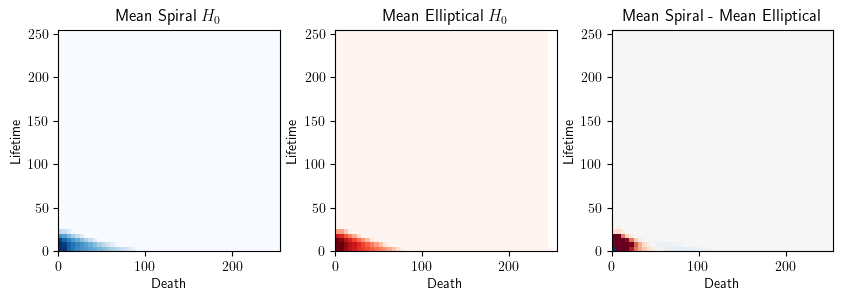

In [235]:
#'''
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(10,3))
ax1.imshow(np.log10(spiral_per_img).T,vmin=0,vmax=2,origin='lower',extent=[0,255,0,255],cmap='Blues')
ax1.set_title('Mean Spiral $H_0$')
ax1.set_xlabel('Death')
ax1.set_ylabel('Lifetime')

ax2.imshow(np.log10(ell_per_img).T,vmin=0,vmax=2,origin='lower',extent=[0,255,0,255],cmap='Reds')
ax2.set_title('Mean Elliptical $H_0$')
ax2.set_xlabel('Death')
ax2.set_ylabel('Lifetime')#'''

ax3.imshow(diff_per_classes.T,cmap='RdBu',vmax=10,vmin=-10,origin='lower',extent=[0,255,0,255])
ax3.set_title('Mean Spiral - Mean Elliptical')
#ax3.colorbar(label='difference')
ax3.set_xlabel('Death')
ax3.set_ylabel('Lifetime')

fig.subplots_adjust(wspace=0.25)

# Classify

In [236]:
from sklearn.preprocessing import MinMaxScaler
flat_scale = MinMaxScaler(feature_range=(0,1)).fit_transform(flat_imgs)
flat_scale.shape
#np.min(flat_scale)

(18876, 5202)

In [237]:
flat_array =flat_scale#flat_imgs# flat_scale#flat_imgs
labels = train_df['class'].values

X_train, X_test, y_train, y_test = train_test_split(flat_array, labels, train_size=0.80,stratify=labels,shuffle=True)#, random_state=42)
#plt.hist(y_train)

In [238]:
t1 = time.time()
clf = MLPClassifier(solver='adam', alpha=1e-2, hidden_layer_sizes=(int(np.shape(flat_array)[1]/5), int(np.shape(flat_array)[1]/50), int(np.shape(flat_array)[1]/500)),max_iter=300,validation_fraction=0.2,
                    early_stopping=True,activation='relu')
clf.fit(X_train, y_train)
t2 = time.time()
print(f'{t2-t1:.2f} s elapsed')
print(f'training accuracy: {clf.score(X_train,y_train)*100:.2f}%')
print(f'training accuracy: {clf.score(X_test,y_test)*100:.2f}%')

/Users/toneill/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


43.00 s elapsed
training accuracy: 89.20%
training accuracy: 82.84%


Text(0.5, 1.0, 'Test set')

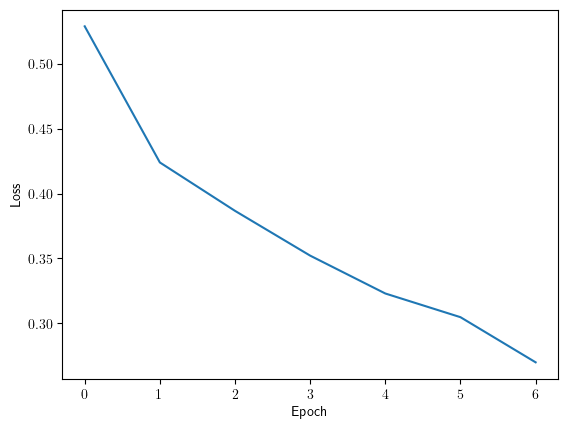

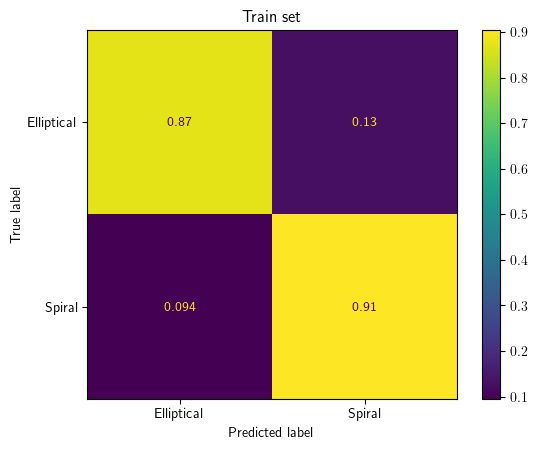

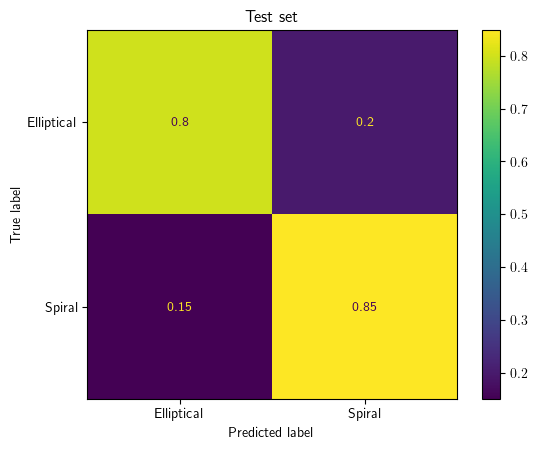

In [239]:
loss_epoch = clf.loss_curve_
plt.figure()
plt.plot(np.arange(len(loss_epoch)),loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')

pred_class = clf.predict(X_train)
labels_plot = y_train
cm = confusion_matrix(labels_plot,pred_class,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Elliptical','Spiral'])
disp.plot()
plt.title('Train set')

pred_class = clf.predict(X_test)
labels_plot = y_test
cm = confusion_matrix(labels_plot,pred_class,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Elliptical','Spiral'])
disp.plot()
plt.title('Test set')

# Visualize correctly/incorrectly classified

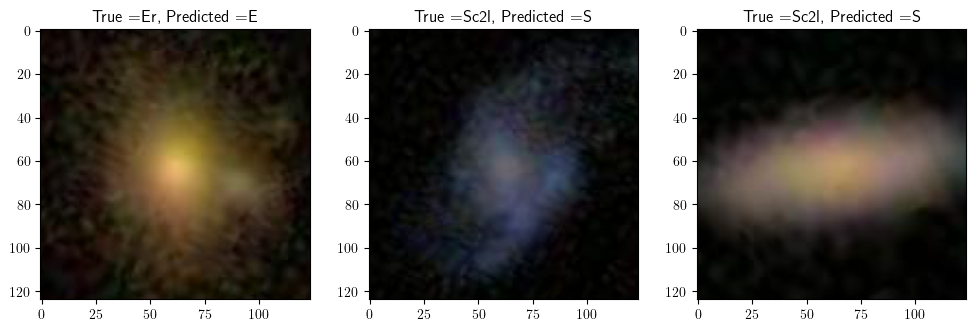

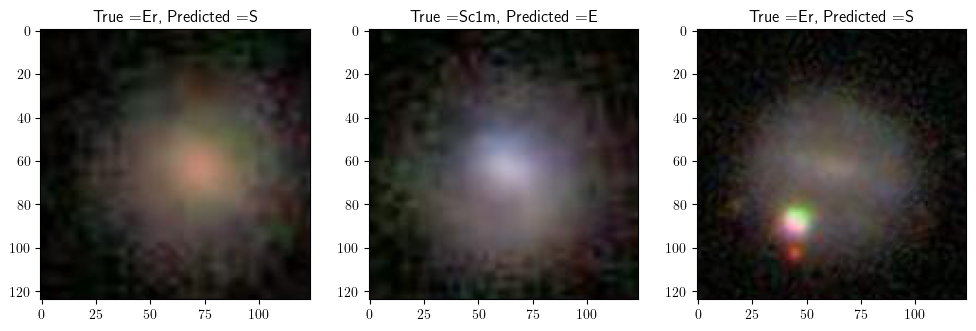

In [180]:
pred_dict = {0:'E',1:'S'}

pred_class = clf.predict(flat_array)
labels_plot = labels

good_class, = np.where(pred_class == labels_plot)
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
axs.ravel()
good_plot = good_class[np.random.randint(0,len(good_class),3)]
for i in range(len(good_plot)):
    ax = axs[i]
    gal_id = train_df['asset_id'].values[good_plot[i]]
    img = mpimg.imread(f'{ddir}{gal_id}.jpg')
    ax.imshow(img[trim_bord:-trim_bord, trim_bord:-trim_bord, :])
    ax.set_title(f"True ={train_df['gz2class'].values[good_plot[i]]}, Predicted ={pred_dict[pred_class[good_plot[i]]]}")

miss_class, = np.where(pred_class != labels_plot)
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
axs.ravel()
miss_plot = miss_class[np.random.randint(0,len(miss_class),3)]
for i in range(len(miss_plot)):
    ax = axs[i]
    gal_id = train_df['asset_id'].values[miss_plot[i]]
    img = mpimg.imread(f'{ddir}{gal_id}.jpg')
    #img = np.array(Image.open(f'{ddir}{gal_id}.jpg').convert('L'),dtype='float32')#[trim_bord:-trim_bord,trim_bord:-trim_bord]
    ax.imshow(img[trim_bord:-trim_bord, trim_bord:-trim_bord])#,cmap='Greys_r')
    ax.set_title(f"True ={train_df['gz2class'].values[miss_plot[i]]}, Predicted ={pred_dict[pred_class[miss_plot[i]]]}")

# Assess classification performance by galaxy type


/var/folders/b2/7lt3z5q170x2xkhr6srvvm_r0000gn/T/ipykernel_80602/802052804.py:9: RuntimeWarning: invalid value encountered in scalar divide
  nfrac_yes = np.sum(result_pred[narm_bool])/np.sum(narm_bool)


Text(0, 0.5, 'Accuracy')

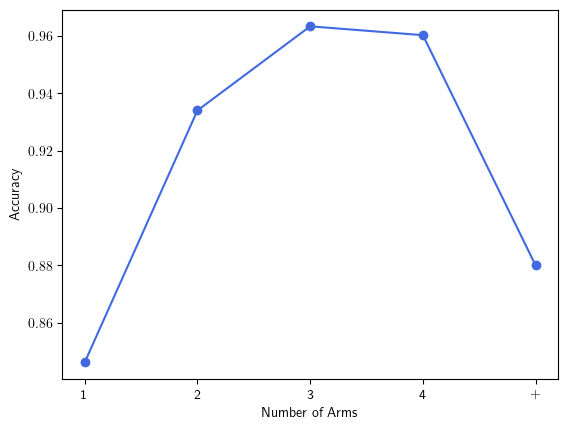

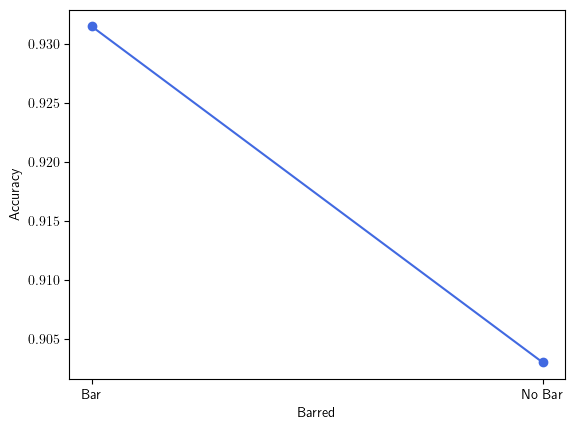

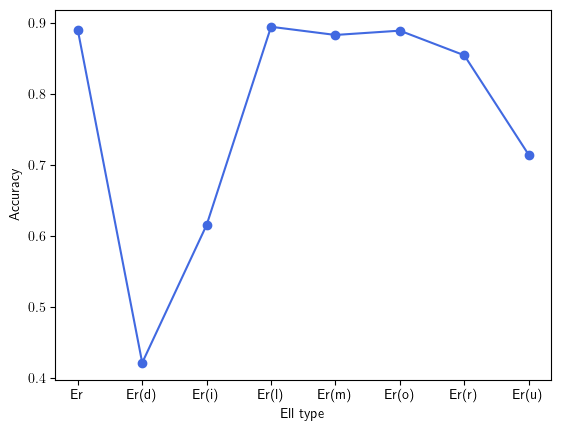

In [181]:
result_pred = pred_class == labels_plot

### classification by spiral arm type
narm_strs = ['1','2','3','4','+','?']
correct_narm = np.full(len(narm_strs),np.nan)
for i in range(len(narm_strs)):
    narm = narm_strs[i]
    narm_bool = train_df['gz2class'].str.find(narm) > 0
    nfrac_yes = np.sum(result_pred[narm_bool])/np.sum(narm_bool)
    correct_narm[i] = nfrac_yes

plt.figure()
plt.plot(narm_strs,correct_narm,marker='o',c='royalblue')
plt.xlabel('Number of Arms')
plt.ylabel('Accuracy')

### classification by bar
has_bar = train_df['gz2class'].str.startswith('SB')
correct_bar = np.full(2,np.nan)
for i in range(len(correct_bar)):
    if i == 0:
        narm_bool = has_bar
    if i == 1:
        narm_bool = ~has_bar
    nfrac_yes = np.sum(result_pred[narm_bool])/np.sum(narm_bool)
    correct_bar[i] = nfrac_yes

plt.figure()
plt.plot(['Bar','No Bar'],correct_bar,marker='o',c='royalblue')
plt.xlabel('Barred')
plt.ylabel('Accuracy')

### classification by elliptical type
gal_types = np.unique(train_df['gz2class'])
ell_types = gal_types[np.where([gal_types[i].startswith('Er') for i in range(len(gal_types))])]
correct_ell = np.full(len(ell_types),np.nan)
for i in range(len(ell_types)):
    etype = ell_types[i]
    narm_bool = train_df['gz2class']==etype
    nfrac_yes = np.sum(result_pred[narm_bool])/np.sum(narm_bool)
    correct_ell[i] = nfrac_yes

plt.figure()
plt.plot(ell_types,correct_ell,marker='o',c='royalblue')
plt.xlabel('Ell type')
plt.ylabel('Accuracy')

# Logistic Regression

In [184]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
train_acc = lr.score(X_train,y_train)
print(f'training accuracy: {train_acc*100:.2f}%')
test_acc = lr.score(X_test,y_test)
print(f'testing accuracy: {test_acc*100:.2f}%')

training accuracy: 88.79%
testing accuracy: 83.98%


Text(0, 0.5, 'lifetime')

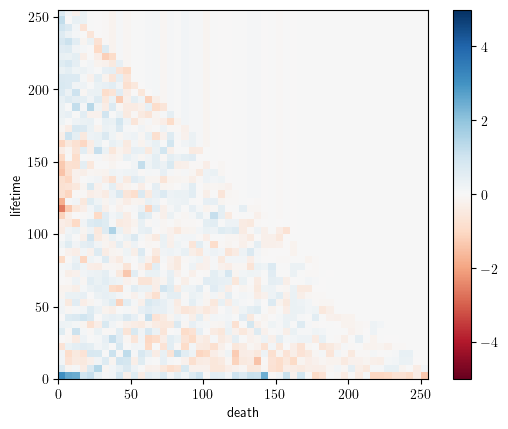

In [185]:

inverse_image = np.copy(lr.coef_[0,0:int(npix)]).reshape(pimgr.resolution)
plt.figure()
plt.imshow(inverse_image.T,cmap='RdBu',vmax=5,vmin=-5,origin='lower',extent=[0,255,0,255])
plt.colorbar()
plt.xlabel('death')
plt.ylabel('lifetime')

# Train a CNN for classification

In [3]:
import torch
from torch.utils.data import Dataset
#import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
#from torchvision import utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [4]:
# Define a custom dataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels,transform=None):
        self.images = images
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        lab = self.labels[idx]

        # Apply transformations if provided
        # See https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
        if self.transform:
            image = self.transform(image)

        return image, lab

In [7]:
df_use = train_df
trim_bord = 150

all_imgs = []
pbar = tqdm(total=len(df_use), unit='galaxies')
for gal_id in df_use['asset_id']:#
    img = mpimg.imread(f'{ddir}{gal_id}.jpg')
    img_use = np.array(img[trim_bord:-trim_bord,trim_bord:-trim_bord,:],dtype='float32')
    all_imgs.append(img_use)
    pbar.update(1)


  0%|          | 0/18876 [00:07<?, ?galaxies/s]

100%|█████████▉| 18829/18876 [03:46<00:00, 858.66galaxies/s]

In [8]:
all_imgs = np.array(all_imgs)
new_dat = np.transpose(all_imgs, (0, 3, 1, 2))
new_dat.shape

(18876, 3, 124, 124)

In [39]:
labels = train_df['class'].values
X_train, X_test, y_train, y_test = train_test_split(new_dat, labels, train_size=0.80,stratify=labels,shuffle=True)

train_dataset = ImageDataset(images=X_train,labels=y_train)#,  transform=transform)
test_dataset = ImageDataset(images=X_test,labels=y_test)#,  transform=transform)

# Create data loader objects for training and test sets
batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        #torch.manual_seed(42)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 31 * 31, 128)  # Calculated after convolutions and pooling
        self.fc2 = nn.Linear(128, 1)  # Binary classification (1 output neuron)
        
        # Dropout layer for regularization
        #self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 31 * 31)  # Flatten the feature maps
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid activation for binary classification
        return x


In [44]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    
    train_losses = np.full(num_epochs,np.nan)
    test_losses = np.full(num_epochs,np.nan)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
    
        for inputs, labels in train_loader:
            optimizer.zero_grad() # Zero the parameter gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels.float().unsqueeze(1))  # Convert labels to float and add dimension
            loss.backward()   # Backward pass
            optimizer.step() # Optimize
            running_loss += loss.item()
            
        epoch_loss = running_loss / len(train_loader)
        train_losses[epoch] = epoch_loss
        print(f'\n Epoch {epoch + 1}, Train Loss: {running_loss / len(train_loader):.2f}')
        
        test_loss = test(model,test_loader,criterion)
        test_losses[epoch] = test_loss
    
        
    # plot loss vs epoch
    plt.figure()
    plt.plot(np.linspace(0,num_epochs,num_epochs),train_losses,marker='o',c='royalblue',label='train')
    plt.plot(np.linspace(0,num_epochs,num_epochs),test_losses,marker='o',c='firebrick',ls='--',label='test')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    
def test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:     
            outputs = model(inputs)  # Forward pass
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            flat_labs = labels.float().unsqueeze(1)
            loss = criterion(outputs,  flat_labs)  # Calculate the loss
            test_loss += loss.item()
            correct += (predicted == flat_labs).sum().item()
            total += labels.size(0)
            
    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.2f}")
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    return avg_test_loss

In [ ]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

In [51]:
model = BinaryCNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer

Epoch 1, Train Loss: 1.16
Test Loss: 0.50
Test Accuracy: 78.05%
Epoch 2, Train Loss: 0.45
Test Loss: 0.43
Test Accuracy: 81.25%
Epoch 3, Train Loss: 0.41
Test Loss: 0.40
Test Accuracy: 83.10%
Epoch 4, Train Loss: 0.38
Test Loss: 0.46
Test Accuracy: 80.27%
Epoch 5, Train Loss: 0.36
Test Loss: 0.37
Test Accuracy: 84.88%
Epoch 6, Train Loss: 0.34
Test Loss: 0.36
Test Accuracy: 84.83%
Epoch 7, Train Loss: 0.32
Test Loss: 0.35
Test Accuracy: 84.98%
Epoch 8, Train Loss: 0.31
Test Loss: 0.35
Test Accuracy: 85.54%
Epoch 9, Train Loss: 0.30
Test Loss: 0.34
Test Accuracy: 85.96%
Epoch 10, Train Loss: 0.29
Test Loss: 0.35
Test Accuracy: 86.15%
Epoch 11, Train Loss: 0.28
Test Loss: 0.38
Test Accuracy: 83.69%
Epoch 12, Train Loss: 0.27
Test Loss: 0.36
Test Accuracy: 84.69%
Epoch 13, Train Loss: 0.26
Test Loss: 0.34
Test Accuracy: 85.70%
Epoch 14, Train Loss: 0.25
Test Loss: 0.33
Test Accuracy: 86.33%
Epoch 15, Train Loss: 0.24
Test Loss: 0.35
Test Accuracy: 85.41%
529.78 s elapsed


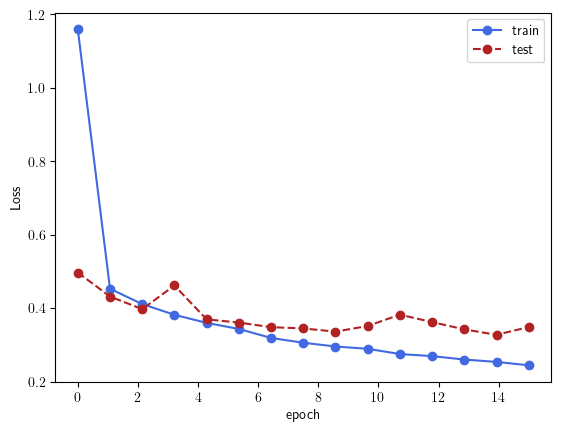

In [52]:
# Train the model
num_epochs = 15
t1 = time.time()
train(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
t2 = time.time()
print(f'{t2-t1:.2f} s elapsed')